### Part 1: Heterogeneous treatment effects using causal trees and forests

For this part, we will be using experimental data for computing heterogeneous effects through causal trees and forests. For all exercises, the predictors $ X $ are all variables that are not the outcome $Y$ or the treatment 
$ D$.

In [132]:
import Pkg
Pkg.add(["CSV", "GLM", "MLJ", "MLJModels", "MLJScikitLearnInterface", "MLJDecisionTreeInterface", "Plots", "CategoricalArrays", "StatsPlots"])

   Resolving package versions...
  No Changes to `C:\Users\almen\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\almen\.julia\environments\v1.10\Manifest.toml`


In [133]:
using CSV, DataFrames, Statistics, GLM, MLJ, MLJModels, Plots, CategoricalArrays, StatsPlots

1.1. Load the data (1 points).

In [134]:
df1 = CSV.read("C:\\Users\\almen\\OneDrive\\Escritorio\\ASS5\\CausalAI-Course\\Labs\\Assignment\\Assignment_5\\data\\experimental\\experimental_control.csv", DataFrame)
first(df1, 5)

Row,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,37,11,1,0,1,1,0.0,0.0,9930.05
2,1,22,9,0,1,0,1,0.0,0.0,3595.89
3,1,30,12,1,0,0,0,0.0,0.0,24909.4
4,1,27,11,1,0,0,1,0.0,0.0,7506.15
5,1,33,8,1,0,0,1,0.0,0.0,289.79


1.2. Find the ATE (1.5 points). With re78 as the outcome variable of interest, find the Average Treatment Effect of participation in the program. Specifically, you should find it by calculating the difference between the means of the treatment group and the control group (the Simple Difference of Means or SDM). What can you say about the program?

In [135]:
# DIFFERENCE OF MEANS
# treated
treatment_group = filter(row -> row.treat == 1, df1)
mean_treatment = mean(treatment_group.re78)

# Calcular las medias
control_group = filter(row -> row.treat == 0, df1)
mean_control = mean(control_group.re78)

# Calcular el ATE (Diferencia Simple de Medias)
ATE = mean_treatment - mean_control

println("ATE (Simple Difference of Means): ", ATE)

ATE (Simple Difference of Means): 1794.3423818501024


In [136]:
# OTHER WAY TO CALCULATE THE ATE
# OLS
model = lm(@formula(re78 ~ treat), df1)
model

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

re78 ~ 1 + treat

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  4554.8      408.046  11.16    <1e-24   3752.85     5356.75
treat        1794.34     632.853   2.84    0.0048    550.574    3038.11
───────────────────────────────────────────────────────────────────────

The treatment has an average effect of : 1794.34

The ATE of 1794.34 indicates that, on average, people who participated in the job training program (treatment) had  1,794.34 more in real income in 1978 compared to those who did not participate (control group).

1.3. Heterogeneous effects with causal trees (3 points). Use causal trees like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to create the auxiliary variable 
Y
∗
 and fit a decision tree regressor. Report the splits the tree finds and interpret them.

In [137]:
y, X = unpack(df1, ==(:re78), !=(:re78))
coerce!(X, Textual => Multiclass)
coerce!(X, Count => Multiclass)

D, X = unpack(X, ==(:treat), !=(:treat))

(CategoricalValue{Int64, UInt32}[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 445×8 DataFrame
 Row │ age   educ  black  hisp  marr  nodegree  re74       re75     
     │ Cat…  Cat…  Cat…   Cat…  Cat…  Cat…      Float64    Float64  
─────┼──────────────────────────────────────────────────────────────
   1 │ 37    11    1      0     1     1             0.0        0.0
   2 │ 22    9     0      1     0     1             0.0        0.0
   3 │ 30    12    1      0     0     0             0.0        0.0
   4 │ 27    11    1      0     0     1             0.0        0.0
   5 │ 33    8     1      0     0     1             0.0        0.0
   6 │ 22    9     1      0     0     1             0.0        0.0
   7 │ 23    12    1      0     0     0             0.0        0.0
   8 │ 32    11    1      0     0     1             0.0        0.0
  ⋮  │  ⋮     ⋮      ⋮     ⋮     ⋮       ⋮          ⋮         ⋮
 439 │ 22    10    0      0     0     1         27864.4    10598.7
 440 │ 44    

In [138]:
LogisticClassifier = @load LogisticClassifier pkg=MLJScikitLearnInterface verbosity=0

log_model = LogisticClassifier()

log_model_machine = machine(log_model,X, D)

fit!(log_model_machine)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJScikitLearnInterface.LogisticClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{34}}, AbstractVector{Multiclass{14}}, AbstractVector{Multiclass{2}}}}, AbstractVector{Multiclass{2}}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Fin

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(penalty = l2, …)
  args: 
    1:	Source @531 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{34}}, AbstractVector{Multiclass{14}}, AbstractVector{Multiclass{2}}}}
    2:	Source @676 ⏎ AbstractVector{Multiclass{2}}


In [139]:
pscore = pdf.(MLJ.predict(log_model_machine, X),1)
y_star = df1.re78 ./ (df1.treat .* pscore .- (1 .- df1.treat) .* (1 .- pscore));

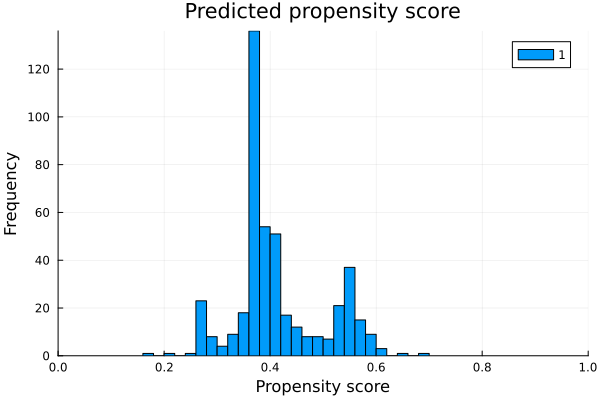

In [141]:
histogram(pscore, bins=30, title="Predicted propensity score", label = "1",
         xlabel="Propensity score", ylabel="Frequency",xlims=(0, 1))

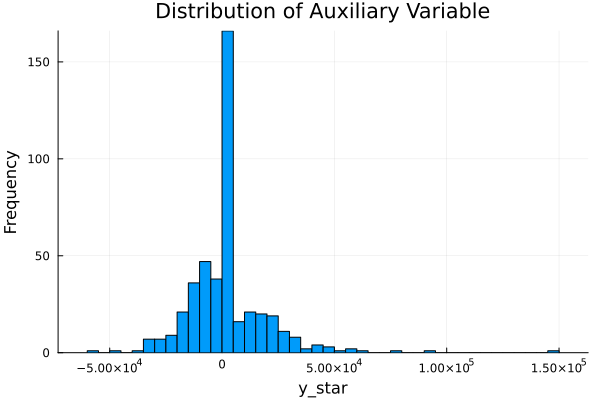

In [143]:
histogram(y_star, bins=50, title="Distribution of Auxiliary Variable", label = false,
         xlabel="y_star", ylabel="Frequency")     

In [144]:
DecisionTreeRegressor = (@load DecisionTreeRegressor pkg=DecisionTree verbosity=0)

tree_model = DecisionTreeRegressor(max_depth = 3)
tree_machine = machine(tree_model, X, y_star)
fit!(tree_machine);

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc DecisionTree.DecisionTreeRegressor` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{34}}, AbstractVector{Multiclass{14}}, AbstractVector{Multiclass{2}}}}, AbstractVector{Continuous}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:Continuous}, AbstractVector{<:Count}, A

In [145]:
fitted_params(tree_machine)[1]

educ < 13.5
├─ re74 < 2653.0
│  ├─ re75 < 775.6
│  │  ├─ 910.7521695984974 (0/299)
│  │  └─ 8407.887657896033 (0/54)
│  └─ re74 < 3571.0
│     ├─ -13153.539814733263 (0/8)
│     └─ -861.7865224418358 (0/75)
└─ 18389.16431900203 (0/9)


Interpretation:

1.4. Heterogeneous effects with causal forests (3 points). Use causal forests like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to use the auxiliary variable 
Y
∗
 computed in the previous exercise and fit a random forest regressor. Report the importance of the prediction variables.


In [146]:
RandomForestRegressor = @load RandomForestRegressor pkg=DecisionTree verbosity = 0

forest_model = RandomForestRegressor(n_trees = 100)
forest_machine = machine(forest_model, X, y_star)
fit!(forest_machine);

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc DecisionTree.RandomForestRegressor` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{34}}, AbstractVector{Multiclass{14}}, AbstractVector{Multiclass{2}}}}, AbstractVector{Continuous}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:Continuous}, AbstractVector{<:Count}, A

In [147]:
# OJO:
fitted_params(forest_machine)[1]

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 176.24
Avg Depth:  20.2

In Julia we have the limitation that when we fit Random Forests, it generates an Ensemble of decision trees. By definition this is correct; however, we do not have access to the singular trees, for this reason  we cannot visualize a more interpretable individual tree. 

OJO:Stil, we are able to see the feature importances.

In [148]:
feature_importances(forest_machine)

8-element Vector{Pair{Symbol, Float64}}:
      :age => 0.3430704128708404
     :re75 => 0.24482702759264874
     :educ => 0.15604036975126642
     :re74 => 0.12883169022435323
    :black => 0.041162511255643644
     :marr => 0.04008937461024997
 :nodegree => 0.02488254112554879
     :hisp => 0.02109607256944899

In [149]:
importances = DataFrame(feature_importances(forest_machine))
importances = DataFrame(variables = names(importances), importance = collect(values(importances[1, :])))

Row,variables,importance
,String,Float64
1,age,0.34307
2,re75,0.244827
3,educ,0.15604
4,re74,0.128832
5,black,0.0411625
6,marr,0.0400894
7,nodegree,0.0248825
8,hisp,0.0210961


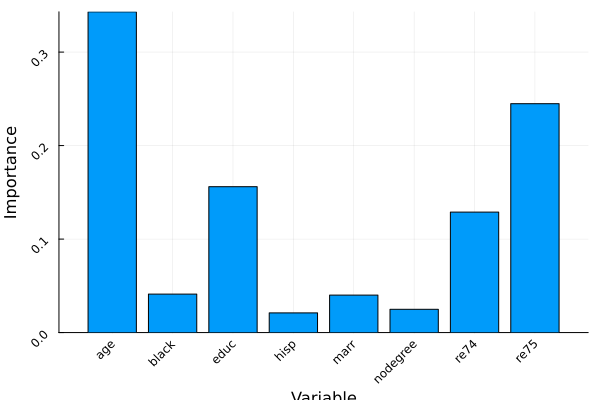

In [150]:
importances.variables = categorical(importances.variables, ordered=true)
sort!(importances, :importance, rev=false)

@df importances bar(:variables, :importance, legend=false)
plot!(xlabel="Variable", ylabel="Importance", xticks=(1:length(importances.variables), levels(importances.variables)), rotation=45)
     

1.5. Plot heterogeneous effects (1.5 points). Plot how the predicted treatment effect changes depending on a variable of your choice.

In [151]:
# Predecir los efectos (esto debe ser previamente calculado)
predicted = MLJ.predict(forest_machine, X)
df1.predicted_effect = predicted


# Crear los bins de 're74', 're75', 'age' y 'educ' si aún no están creados
df1.re74_bins = floor.(df1.re74 ./ 500) .* 500
df1.re75_bins = floor.(df1.re75 ./ 500) .* 500
df1.age_bins = floor.(df1.age ./ 5) .* 5
df1.age_bins .= ifelse.(df1.age_bins .== 15, 17, df1.age_bins)

445-element Vector{Real}:
 35.0
 20.0
 30.0
 25.0
 30.0
 20.0
 20.0
 30.0
 20.0
 30.0
  ⋮
 25.0
 25.0
 20.0
 40.0
 20.0
 25.0
 25.0
 25.0
 20.0

In [152]:
# Agrupar por 're74_bins' y calcular el efecto medio
re74_effect_bins = combine(groupby(df1, :re74_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(re74_effect_bins, :re74_bins)
# Agrupar por 're75_bins' y calcular el efecto medio
re75_effect_bins = combine(groupby(df1, :re75_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(re75_effect_bins, :re75_bins)

# Agrupar por 'age_bins' y calcular el efecto medio
age_effect_bins = combine(groupby(df1, :age_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(age_effect_bins, :age_bins)

# Agrupar por 'educ' y calcular el efecto medio
educ_effect_bins = combine(groupby(df1, :educ), :predicted_effect => mean => :mean_predicted_effect)
sort!(educ_effect_bins, :educ)

Row,educ,mean_predicted_effect
,Int64,Float64
1,3,-2083.42
2,4,7279.61
3,5,13255.3
4,6,-1515.83
5,7,-1935.19
6,8,-193.976
7,9,667.12
8,10,-242.847
9,11,2462.25


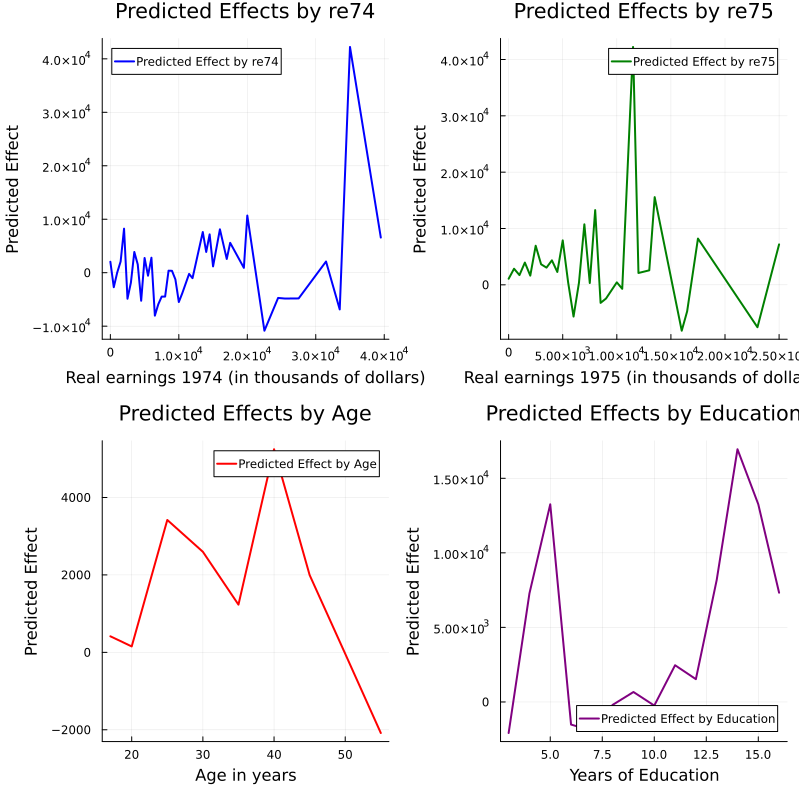

In [153]:
# Graficar los efectos predichos para las diferentes variables
p1 = plot(re74_effect_bins.re74_bins, re74_effect_bins.mean_predicted_effect, 
          label="Predicted Effect by re74", color=:blue, xlabel="Real earnings 1974 (in thousands of dollars)", 
          ylabel="Predicted Effect", lw=2, title="Predicted Effects by re74")

p2 = plot(re75_effect_bins.re75_bins, re75_effect_bins.mean_predicted_effect, 
          label="Predicted Effect by re75", color=:green, xlabel="Real earnings 1975 (in thousands of dollars)", 
          ylabel="Predicted Effect", lw=2, title="Predicted Effects by re75")

p3 = plot(age_effect_bins.age_bins, age_effect_bins.mean_predicted_effect, 
          label="Predicted Effect by Age", color=:red, xlabel="Age in years", ylabel="Predicted Effect", 
          lw=2, title="Predicted Effects by Age")

p4 = plot(educ_effect_bins.educ, educ_effect_bins.mean_predicted_effect, 
          label="Predicted Effect by Education", color=:purple, xlabel="Years of Education", 
          ylabel="Predicted Effect", lw=2, title="Predicted Effects by Education")

# Combinar todos los gráficos en una sola ventana
plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 800))
